In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**News Genre Classification**

Source : https://www.machinehack.com/course/predict-the-news-category-hackathon/

Load Basic Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import re
import string
from sklearn.model_selection import train_test_split,KFold
from sklearn import ensemble, metrics, model_selection, naive_bayes
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from wordcloud import WordCloud, STOPWORDS



In [2]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
StopWords = set(stopwords.words('english')) 



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load Train and Test datasets

In [0]:
TrainNews = pd.read_excel('/content/drive/My Drive/TextGenreClassification/Data_Train.xlsx',converters={'STORY':str,'SECTION':str})
TestNews =pd.read_excel('/content/drive/My Drive/TextGenreClassification/Data_Test.xlsx',converters={'STORY':str,'SECTION':str})

In [5]:
print("Train dataset has {} columns and  {} rows ".format(TrainNews.shape[0],TrainNews.shape[1]))
print("Test dataset has {} columns and  {} rows ".format(TestNews.shape[0],TestNews.shape[1]))


Train dataset has 7628 columns and  2 rows 
Test dataset has 2748 columns and  1 rows 


Check the class balance of Genres in the Train Dataset

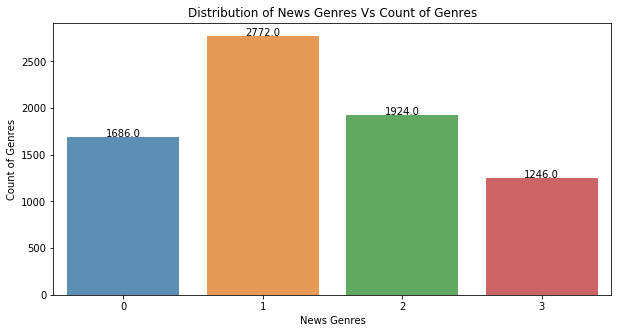

In [17]:
GenreCounts = TrainNews['SECTION'].value_counts()
plt.figure(figsize=(10,5))
ax=sns.barplot(GenreCounts.index, GenreCounts.values, alpha=0.8)
ax.set_xlabel('News Genres')
ax.set_ylabel('Count of Genres')
ax.set_title('Distribution of News Genres Vs Count of Genres')
for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            h + 3,
            h,
            ha="center")
plt.show()

Lets Try to create features
> Meta Features

    Number of unique words in the text

    Number of characters in the text

    Number of stopwords

    Number of punctuations

    Number of upper case words

    Number of title case words
    
    Average length of the words








In [0]:
def GenerateMetaFeatures(Txt):
    words = len(str(Txt.split()))
    UniqWords = len(set(str(Txt.split())))
    Chars = len(str(Txt))
    NumStopWords = len([w for w in str(Txt).lower().split() if w in StopWords])
    NumPunct = len([c for c in str(Txt) if c in string.punctuation])
    UpperWords = len([w for w in str(Txt).split() if w.isupper()])
    WordsTitle = len([w for w in str(Txt).split() if w.istitle()])
    MeanWordLen = np.mean([len(w) for w in str(Txt).split()])    
    return(words,UniqWords,Chars,NumStopWords,NumPunct,UpperWords,WordsTitle,MeanWordLen)

for df in [TrainNews,TestNews]:
  df[['Words','UniqueWords','Chars','NumStopWords','NumPunct','UpperWords','WordsTitle','MeanWordLen']] = df.apply(lambda row: GenerateMetaFeatures(row['STORY']), axis=1,result_type="expand")

Lets check if the meta features are of any value to our modelling 

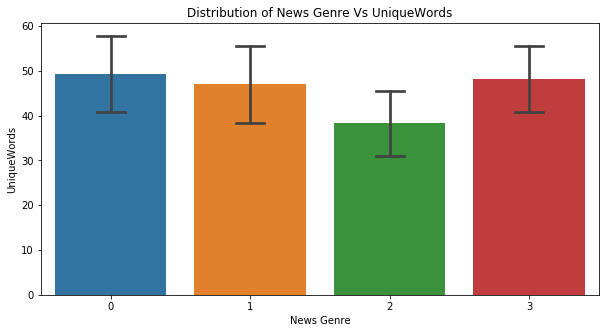

In [49]:
#Show adoption News Genre Vs Words
plt.figure(figsize=(10,5))
ax = sns.barplot(x="SECTION", y="Words",ci='sd',capsize=.2, data=TrainNews)
ax.set_xlabel('News Genre')
ax.set_ylabel('Words')
ax.set_title('Distribution of News Genre Vs Words')
plt.show()

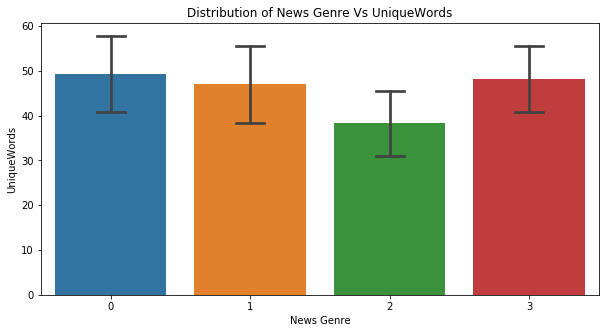

In [50]:
#Show adoption News Genre Vs UniqueWords
plt.figure(figsize=(10,5))
ax = sns.barplot(x="SECTION", y="UniqueWords",ci='sd',capsize=.2, data=TrainNews)
ax.set_xlabel('News Genre')
ax.set_ylabel('UniqueWords')
ax.set_title('Distribution of News Genre Vs UniqueWords')
plt.show()

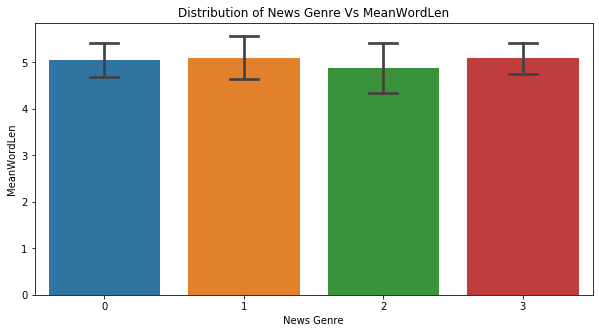

In [51]:
#Show adoption News Genre Vs MeanWordLength
plt.figure(figsize=(10,5))
ax = sns.barplot(x="SECTION", y="MeanWordLen",ci='sd',capsize=.2, data=TrainNews)
ax.set_xlabel('News Genre')
ax.set_ylabel('MeanWordLen')
ax.set_title('Distribution of News Genre Vs MeanWordLen')
plt.show()

Store the text of News Genre in a Python list

In [0]:
G0 = TrainNews[TrainNews.SECTION=="0"]["STORY"].values
G1 = TrainNews[TrainNews.SECTION=="1"]["STORY"].values
G2 = TrainNews[TrainNews.SECTION=="2"]["STORY"].values
G3 = TrainNews[TrainNews.SECTION=="2"]["STORY"].values

(-0.5, 399.5, 199.5, -0.5)

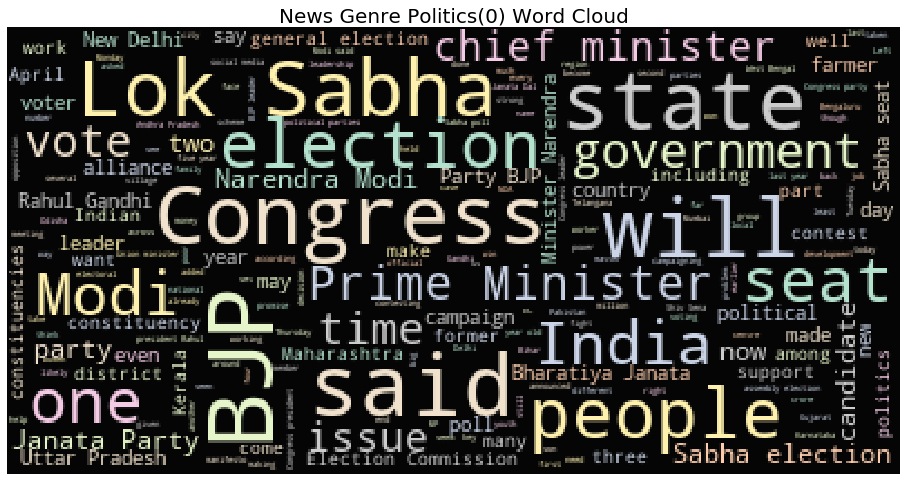

In [61]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
                stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(G0))
plt.title("News Genre Politics(0) Word Cloud", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

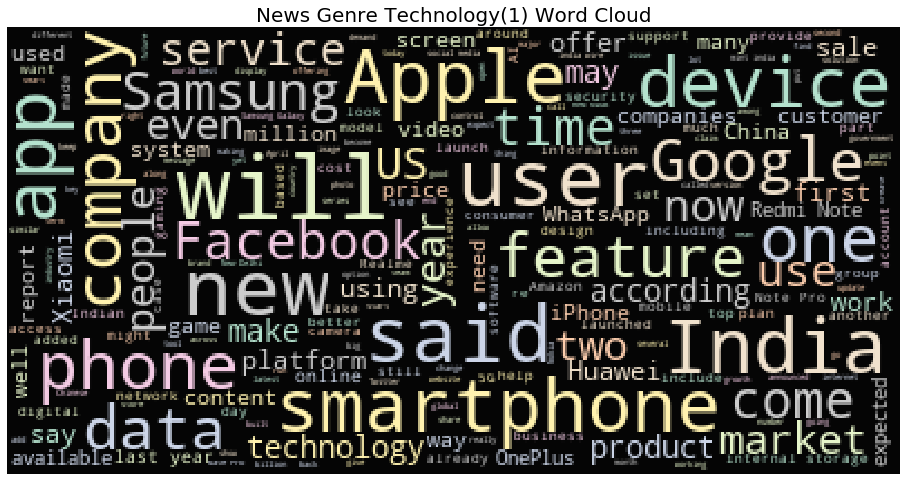

In [62]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
                stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(G1))
plt.title("News Genre Technology(1) Word Cloud", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

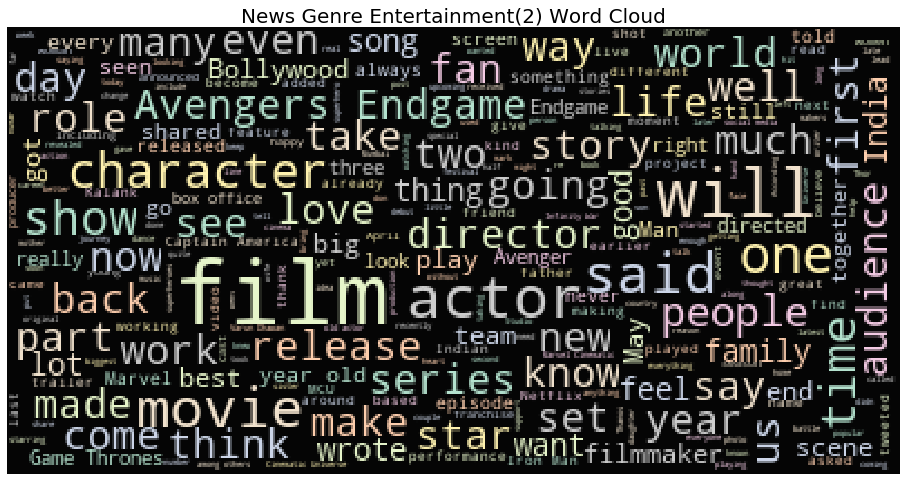

In [63]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
                stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(G2))
plt.title("News Genre Entertainment(2) Word Cloud", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

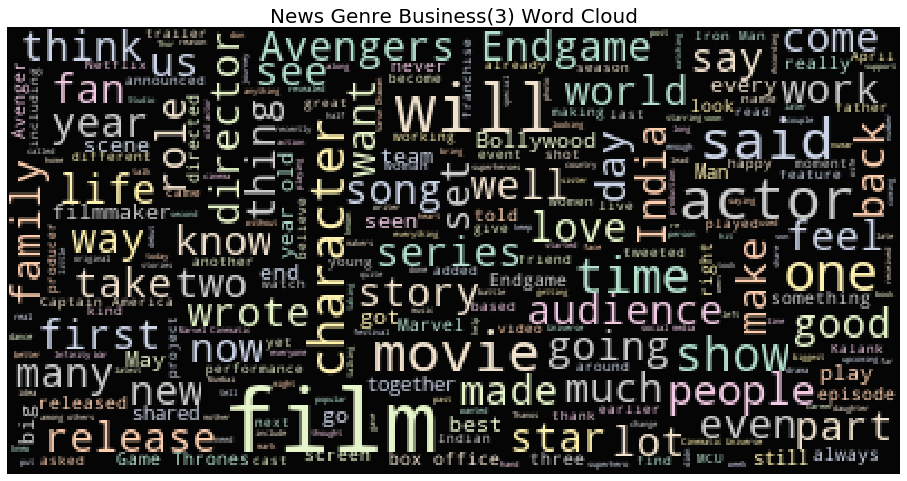

In [64]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
                stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(G3))
plt.title("News Genre Business(3) Word Cloud", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

Lets Train Basic Model with these meta features
 - XGBoost Classifier

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X_Train = TrainNews.drop(['STORY','SECTION'],axis=1)
Y_Train = TrainNews[['SECTION']]
Y_Train = label_encoder.fit_transform(Y_Train)

X_Test = TestNews.drop(['STORY'],axis=1)
#Split train data set 
train_x, val_x, train_y, val_y = train_test_split(X_Train, Y_Train, test_size = 0.25, random_state = 123)

nc = len(np.unique(Y_Train))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
def runXGB(X_Train, Y_Train, X_Test, Y_Test=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    param['num_class'] = nc
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(X_Train, label=Y_Train)

    if Y_Test is not None:
        xgtest = xgb.DMatrix(X_Test, label=Y_Test)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [8]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([TrainNews.shape[0], 4])
for dev_index, val_index in kf.split(X_Train):
    dev_X, val_X = X_Train.loc[dev_index], X_Train.loc[val_index]
    dev_y, val_y = Y_Train[dev_index], Y_Train[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, X_Test, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.36046	test-mlogloss:1.36082
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.1425	test-mlogloss:1.14529
[40]	train-mlogloss:1.04336	test-mlogloss:1.05692
[60]	train-mlogloss:0.997691	test-mlogloss:1.01959
[80]	train-mlogloss:0.95853	test-mlogloss:0.990228
[100]	train-mlogloss:0.929008	test-mlogloss:0.971509
[120]	train-mlogloss:0.904724	test-mlogloss:0.958425
[140]	train-mlogloss:0.886402	test-mlogloss:0.949663
[160]	train-mlogloss:0.869179	test-mlogloss:0.94238
[180]	train-mlogloss:0.853684	test-mlogloss:0.93601
[200]	train-mlogloss:0.83963	test-mlogloss:0.930271
[220]	train-mlogloss:0.829105	test-mlogloss:0.926109
[240]	train-mlogloss:0.816986	test-mlogloss:0.922275
[260]	train-mlogloss:0.806185	test-mlogloss:0.919252
[280]	train-mlogloss:0.797315	test-mlogloss:0.918065
[300]	train-mlogloss:0.787855	test-mlogloss:0.916095
[320]	train-mloglos

In [9]:
results = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1)) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(val_y, np.argmax(pred_val_y,axis=1)) )
print ('Report : ')
print (classification_report(val_y, np.argmax(pred_val_y,axis=1)) )

Confusion Matrix :
[[163 131  43   8]
 [ 48 401  59  55]
 [ 14  70 297   2]
 [ 15 116  13  91]]
Accuracy Score : 0.6238532110091743
Report : 
              precision    recall  f1-score   support

           0       0.68      0.47      0.56       345
           1       0.56      0.71      0.63       563
           2       0.72      0.78      0.75       383
           3       0.58      0.39      0.47       235

    accuracy                           0.62      1526
   macro avg       0.64      0.59      0.60      1526
weighted avg       0.63      0.62      0.62      1526



So with Meta features we got a score of 0.912 (Not Bad)

Lets visualise the important features

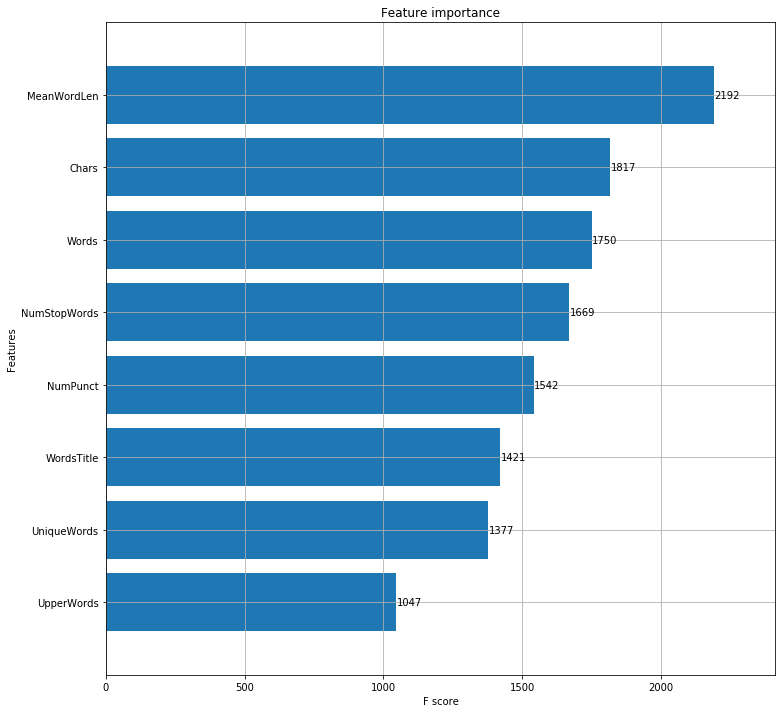

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Create Extra features by Vectorizer
Tf-Idf Vectorizer





In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

In [0]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3),max_features=15000)
full_tfidf = tfidf_vec.fit_transform(TrainNews['STORY'].values.tolist() + TestNews['STORY'].values.tolist())
train_tfidf = tfidf_vec.transform(TrainNews['STORY'].values.tolist())
test_tfidf = tfidf_vec.transform(TestNews['STORY'].values.tolist())

In [45]:
train_tfidf.shape

(7628, 15000)

In [0]:
df1 = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
df2 = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

In [0]:
TrainNews_tfidf = pd.concat([TrainNews,df1],axis=1)
TestNews_tfidf = pd.concat([TestNews,df2],axis=1)

TrainNews_tfidf = TrainNews_tfidf.drop(['STORY'],axis=1)

In [49]:
X_Train = TrainNews_tfidf.drop(['SECTION'],axis=1)
Y_Train = TrainNews_tfidf[['SECTION']]
Y_Train = label_encoder.fit_transform(Y_Train)

X_Test = TestNews_tfidf.drop(['STORY'],axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
def runXGB(X_Train, Y_Train, X_Test, Y_Test=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    param['num_class'] = nc
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(X_Train, label=Y_Train)

    if Y_Test is not None:
        xgtest = xgb.DMatrix(X_Test, label=Y_Test)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [0]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([TrainNews.shape[0], 4])
for dev_index, val_index in kf.split(X_Train):
    dev_X, val_X = X_Train.loc[dev_index], X_Train.loc[val_index]
    dev_y, val_y = Y_Train[dev_index], Y_Train[val_index]
    pred_val_y, pred_test_y, modelXGB = runXGB(dev_X, dev_y, val_X, val_y, X_Test, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

cv scores :  [0.1471736111672701]

In [43]:
results = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1)) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(val_y, np.argmax(pred_val_y,axis=1)) )
print ('Report : ')
print (classification_report(val_y, np.argmax(pred_val_y,axis=1)) )

Confusion Matrix :
[[318  13   9   5]
 [  2 545   9   7]
 [  3   4 376   0]
 [  2  10   0 223]]
Accuracy Score : 0.9580602883355177
Report : 
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       345
           1       0.95      0.97      0.96       563
           2       0.95      0.98      0.97       383
           3       0.95      0.95      0.95       235

    accuracy                           0.96      1526
   macro avg       0.96      0.96      0.96      1526
weighted avg       0.96      0.96      0.96      1526



Let’s look at the top 50 most common terms

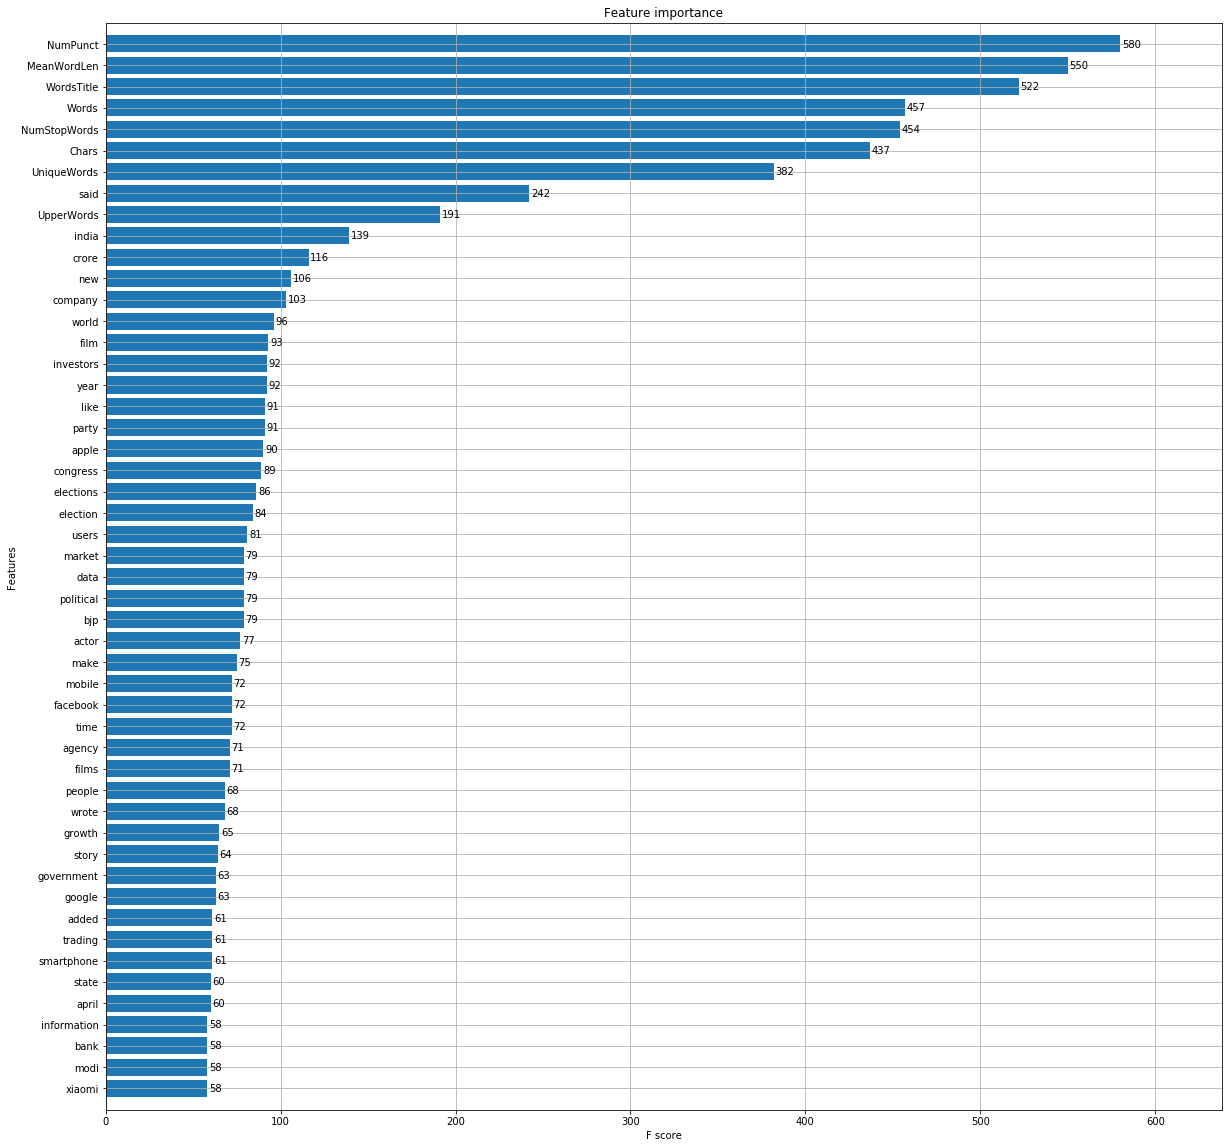

In [55]:
fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(modelXGB, max_num_features=50, height=0.8, ax=ax)
plt.show()